# First demo : basic



##  Image digits classifier

Following end-to-end workflow classify an image digit database. 

#### The goals to write the following programs are as follow:

1. creating an MLP and CNN neural network that classifies real-world image digits.
2. building, 
3. training, 
4. testing, 
5. validating 
6. callbacks and
7. saving the Tensorflow model


##### Database: SVHN dataset

* The dataset URL is: http://ufldl.stanford.edu/housenumbers/
* The train set URL is: http://ufldl.stanford.edu/housenumbers/train.tar.gz
* The test set URL is: http://ufldl.stanford.edu/housenumbers/test.tar.gz



In [44]:
import tensorflow as tf
from scipy.io import loadmat

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
import os
import numpy as np
import pandas as pd
from random import sample,randint
import matplotlib.pyplot as plt
from skimage import io

In [45]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [46]:
# Data loading 
train = loadmat('/content/gdrive/My_Drive/datasets/train_32x32.mat')
test = loadmat('/content/gdrive/My_Drive/datasets/test_32x32.mat')

## 1.  Preprocessing the dataset

In [47]:
"""
Extracting the training and testing images 
train and test are dictionaries 
with keys X and y for the input images 
and labels respectively.
"""

x_train = train['X']
y_train = train['y']
x_test  = test['X']
y_test  = test['y']


In [48]:
""" 
correcting the label 10 to 0

"""

def label_correction(labels):
    
    labels=[e[0] for e in labels]
    
    labels=np.asarray(labels)

    labels=np.where(labels == 10, 0 , labels )
    
    labels=[[e] for e in labels]
    
    label = np.stack(labels,axis=0)
  
    return label


y_train=label_correction(y_train)
y_test=label_correction(y_test)
print(y_train.shape)
print(y_test.shape)

(73257, 1)
(26032, 1)


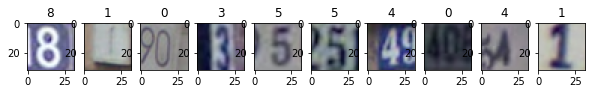

In [49]:
"""
Displaying 10 images along with their labels

"""
samlpe_list=sample(range(x_train.shape[3]), k=10)
   
figs, axs = plt.subplots(1, 10, figsize=(10, 1))
for ax,element in zip(axs,samlpe_list):
    ax.set_title(str(y_train[element][0]))
    ax.imshow(x_train[:,:,:,element])


In [50]:
"""
Convert the training and test images to grayscale

"""

x_train = np.average(x_train,axis = 2) 
x_test  = np.average(x_test,axis = 2)


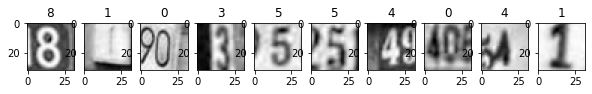

In [51]:

"""
Displaying 10 grayscale images along with their labels
 
"""

fig, axs = plt.subplots(1, 10, figsize=(10, 1))
    
for ax,element in zip(axs,samlpe_list):
    ax.set_title(str(y_train[element][0]))
    ax.imshow(x_train[...,element],cmap='gray')

In [52]:

"""
The Conv2D operation currently only supports the NHWC tensor format on the CPU.
The op was given the format: NCHW

(32, 32, 26032) --> (26032, 32, 32)
(32, 32, 26032) --> (26032, 32, 32, 1)

"""
def build_NHWC_tensor_format(data):
    
    tensor_data = tf.transpose(data, perm = [2,0,1])
    
    formated_data = tensor_data[...,np.newaxis]
    
    return formated_data
    
x_train = build_NHWC_tensor_format(x_train)
x_test  = build_NHWC_tensor_format(x_test )
    
print('x_train : ',x_train.shape)
print('x_test  : ',x_test .shape)




x_train :  (73257, 32, 32, 1)
x_test  :  (26032, 32, 32, 1)


In [53]:
"""
Function to estimate the accuracy
"""
def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

## 2. MLP neural network classifier (Multilayer perceptron)
* Building an MLP classifier model using the Sequential API.

In [54]:


def get_MLP_model(input_shape,weight_decay,rate):
    

    model = Sequential ([
    
    Flatten(input_shape=(32, 32,1),name='layer_0',data_format='channels_last'),

        
    Dense(128,kernel_initializer='he_uniform',bias_initializer="ones", activation='relu', name='dense_1'),    
    BatchNormalization(),
    Dropout(rate),  

    Dense(68,kernel_regularizer=regularizers.l2(weight_decay), activation='relu',name= 'dense_2'),    
    BatchNormalization(),
    Dropout(rate), 
        
    Dense(32,kernel_regularizer=regularizers.l2(weight_decay), activation='relu',name= 'dense_3'),  
    BatchNormalization(), 
    Dropout(rate),   

    Dense(16,kernel_regularizer=regularizers.l2(weight_decay), activation='relu',name= 'dense_4'),    
    BatchNormalization(),
    Dropout(rate),
        
    Dense(10, activation='softmax',name= 'dense_5'),   
     
    ])
    return model

In [55]:


"""
 Print out the model summary (using the summary() method)

"""

MLP_model = get_MLP_model(x_train,0.3,0.001)
MLP_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_0 (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 68)                8772      
_________________________________________________________________
batch_normalization_7 (Batch (None, 68)                272       
_________________________________________________________________
dropout_7 (Dropout)          (None, 68)               

In [56]:
"""
 Compiling the model 

"""
def compile_model(model):

    opt= tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    loss='sparse_categorical_crossentropy',

    model.compile(
                    optimizer = opt,
                    loss= loss,
                    metrics= ['acc'])
    
compile_model(MLP_model) 

In [57]:
"""

 1. Using callbacks during training, 
 2. Using ModelCheckpoint callback.

"""

def mlp_get_checkpoint_every_epoch():

    checkpoint = ModelCheckpoint('mlp/checkpoints_every_epoch/checkpoint_{epoch:03d}',save_weights_only=True)
    
    return checkpoint

def mlp_get_checkpoint_best_only_entire_model():

    checkpoint = ModelCheckpoint('mlp/checkpoints_best_only_entire_model/checkpoint',
                                 save_weights_only=False,
                                save_best_only=True,
                                monitor='val_acc')
    return checkpoint    

def mlp_get_checkpoint_best_only():

    checkpoint = ModelCheckpoint('mlp/checkpoints_best_only/checkpoint',
                                 save_weights_only=True,
                                save_best_only=True,
                                monitor='val_acc')
    return checkpoint

def mlp_get_early_stopping():

    early_stopping=EarlyStopping(monitor='val_acc',
                                patience=5)
    
    return early_stopping

mlp_checkpoint_every_epoch = mlp_get_checkpoint_every_epoch()
mlp_mlp_checkpoint_best_only = mlp_get_checkpoint_best_only()
mlp_early_stopping = mlp_get_early_stopping()
mlp_best_entire_model = mlp_get_checkpoint_best_only_entire_model()

mlp_callbacks = [mlp_checkpoint_every_epoch, mlp_mlp_checkpoint_best_only, mlp_early_stopping, mlp_best_entire_model]


In [58]:
"""
training the MLP model

"""

mlp_history = MLP_model.fit(x_train, y_train, epochs=30,batch_size=32,
                            validation_split= 0.15 ,callbacks=mlp_callbacks, verbose= 2)



Epoch 1/30
INFO:tensorflow:Assets written to: mlp/checkpoints_best_only_entire_model/checkpoint/assets
1946/1946 - 12s - loss: 19.3449 - acc: 0.2822 - val_loss: 5.9641 - val_acc: 0.3837
Epoch 2/30
INFO:tensorflow:Assets written to: mlp/checkpoints_best_only_entire_model/checkpoint/assets
1946/1946 - 12s - loss: 3.1574 - acc: 0.5281 - val_loss: 1.9428 - val_acc: 0.5772
Epoch 3/30
INFO:tensorflow:Assets written to: mlp/checkpoints_best_only_entire_model/checkpoint/assets
1946/1946 - 12s - loss: 1.5352 - acc: 0.6455 - val_loss: 1.2747 - val_acc: 0.6860
Epoch 4/30
1946/1946 - 10s - loss: 1.2009 - acc: 0.6857 - val_loss: 1.1518 - val_acc: 0.6816
Epoch 5/30
INFO:tensorflow:Assets written to: mlp/checkpoints_best_only_entire_model/checkpoint/assets
1946/1946 - 12s - loss: 1.0392 - acc: 0.7194 - val_loss: 1.0255 - val_acc: 0.7200
Epoch 6/30
1946/1946 - 10s - loss: 0.9690 - acc: 0.7337 - val_loss: 1.0001 - val_acc: 0.7191
Epoch 7/30
INFO:tensorflow:Assets written to: mlp/checkpoints_best_only_e

In [59]:
print(mlp_history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


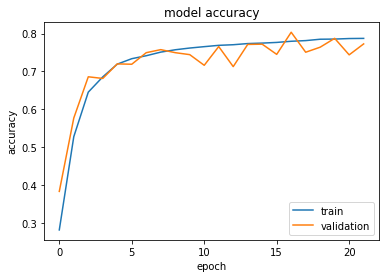

In [60]:
"""
Plot accuracy vs epoch for training and validation sets.

"""

plt.plot(mlp_history.history['acc'])
plt.plot(mlp_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

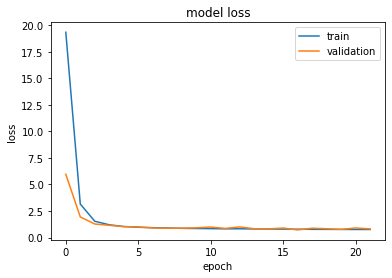

In [61]:

"""
Plot the learning curves for loss vs epoch
 for both training and validation sets.

"""

plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [62]:
"""
Evaluation of the loss and accuracy of the trained model on the test set.

"""

test_loss,test_acc =MLP_model.evaluate(x_test, y_test, verbose=2)


814/814 - 2s - loss: 0.9125 - acc: 0.7456


## 3. CNN neural network classifier

In [63]:
l2_reg = l2(1e-5)

In [64]:


def get_CNN_model(input_shape,weight_decay,rate):
    
    """
    Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D,
    BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output.
    """
    
    CNN_model = Sequential([
      Conv2D(16,(3,3),padding = 'SAME',kernel_regularizer = l2_reg, input_shape =(32, 32, 1)),
      MaxPooling2D((2,2)),
      BatchNormalization(),
      Dropout(0.2),
      Conv2D(4,(3,3),padding = 'SAME',kernel_regularizer = l2_reg),
      MaxPooling2D((2,2)),
      Conv2D(2,(3,3),padding = 'SAME',kernel_regularizer = l2_reg),
      Flatten(),
      Dense(32, activation = 'relu',kernel_regularizer = l2_reg),
      Dense(10, activation = 'softmax',kernel_regularizer = l2_reg)
      ])

    return CNN_model


In [65]:

CNN_model = get_CNN_model(x_train,0.3,0.001)

CNN_model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 16)        64        
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 4)         580       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 4)           0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 2)          

In [66]:
def cnn_get_checkpoint_every_epoch():
    
    checkpoint = ModelCheckpoint('cnn/checkpoints_every_epoch/checkpoint_{epoch:03d}',save_weights_only=True)
    
    return checkpoint

def cnn_get_checkpoint_best_only_entire_model():
    
    checkpoint = ModelCheckpoint('cnn/checkpoints_best_only_entire_model/checkpoint',
                                 save_weights_only=False,
                                save_best_only=True,
                                monitor='val_acc')
    return checkpoint 

def cnn_get_checkpoint_best_only():
    
    checkpoint = ModelCheckpoint('cnn/checkpoints_best_only/checkpoint',
                                 save_weights_only=True,
                                save_best_only=True,
                                monitor='val_acc')
    return checkpoint

def cnn_get_early_stopping():
    
    early_stopping=EarlyStopping(monitor='val_acc',
                                patience=5)
    
    return early_stopping


cnn_checkpoint_every_epoch = cnn_get_checkpoint_every_epoch()
cnn_checkpoint_best_only = cnn_get_checkpoint_best_only()
cnn_early_stopping = cnn_get_early_stopping()
cnn_best_entire_model =cnn_get_checkpoint_best_only_entire_model()

cnn_callbacks = [cnn_checkpoint_every_epoch, cnn_checkpoint_best_only, cnn_early_stopping,cnn_best_entire_model]

In [67]:

"""
 Compile and train the model
"""

CNN_model.compile(optimizer = 'adam',
                                 loss = 'sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
 
cnn_train_val_history = CNN_model.fit(x_train, y_train, epochs=30,batch_size=64,
                                      validation_split= 0.2,
                                      callbacks=cnn_callbacks,
                                      verbose= 2 )




Epoch 1/30
916/916 - 4s - loss: 1.6007 - accuracy: 0.4598 - val_loss: 1.0066 - val_accuracy: 0.6885
Epoch 2/30
916/916 - 3s - loss: 0.9042 - accuracy: 0.7255 - val_loss: 0.8188 - val_accuracy: 0.7581
Epoch 3/30
916/916 - 3s - loss: 0.7950 - accuracy: 0.7612 - val_loss: 0.7812 - val_accuracy: 0.7704
Epoch 4/30
916/916 - 3s - loss: 0.7442 - accuracy: 0.7778 - val_loss: 0.7186 - val_accuracy: 0.7894
Epoch 5/30
916/916 - 3s - loss: 0.7081 - accuracy: 0.7894 - val_loss: 0.6957 - val_accuracy: 0.7938
Epoch 6/30
916/916 - 3s - loss: 0.6845 - accuracy: 0.7955 - val_loss: 0.7066 - val_accuracy: 0.7910
Epoch 7/30
916/916 - 3s - loss: 0.6632 - accuracy: 0.8033 - val_loss: 0.6946 - val_accuracy: 0.7928
Epoch 8/30
916/916 - 3s - loss: 0.6485 - accuracy: 0.8071 - val_loss: 0.6766 - val_accuracy: 0.7998
Epoch 9/30
916/916 - 3s - loss: 0.6378 - accuracy: 0.8104 - val_loss: 0.6533 - val_accuracy: 0.8084
Epoch 10/30
916/916 - 3s - loss: 0.6277 - accuracy: 0.8133 - val_loss: 0.6530 - val_accuracy: 0.8079

In [68]:
print(cnn_train_val_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


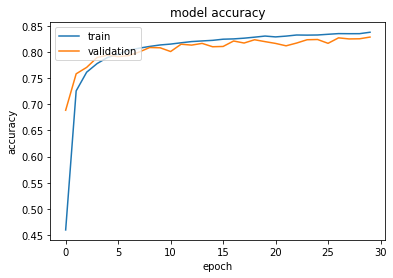

In [69]:

plt.plot(cnn_train_val_history.history['accuracy'])
plt.plot(cnn_train_val_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

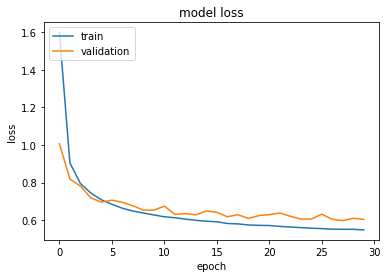

In [70]:

plt.plot(cnn_train_val_history.history['loss'])
plt.plot(cnn_train_val_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [71]:
# Evaluation of the loss and accuracy of the trained model on the test set.

test_loss,test_acc = CNN_model.evaluate(x_test, y_test, verbose=2)

814/814 - 2s - loss: 0.7041 - accuracy: 0.8069


## 4.  Model predictions


In [72]:

# Loading the best weights for the MLP and CNN models that hasve been saved during the training phase.

CNN_model.save('/content/cnn/checkpoints_best_only')

MLP_model.save('/content/mlp/checkpoints_best_only')


INFO:tensorflow:Assets written to: /content/cnn/checkpoints_best_only/assets
INFO:tensorflow:Assets written to: /content/mlp/checkpoints_best_only/assets


In [73]:
best_weight_mlp= load_model('/content/mlp/checkpoints_best_only')

best_weight_cnn= load_model('/content/cnn/checkpoints_best_only')


In [74]:
# conver tensorflow to numpy

np_x_test=x_test.numpy()


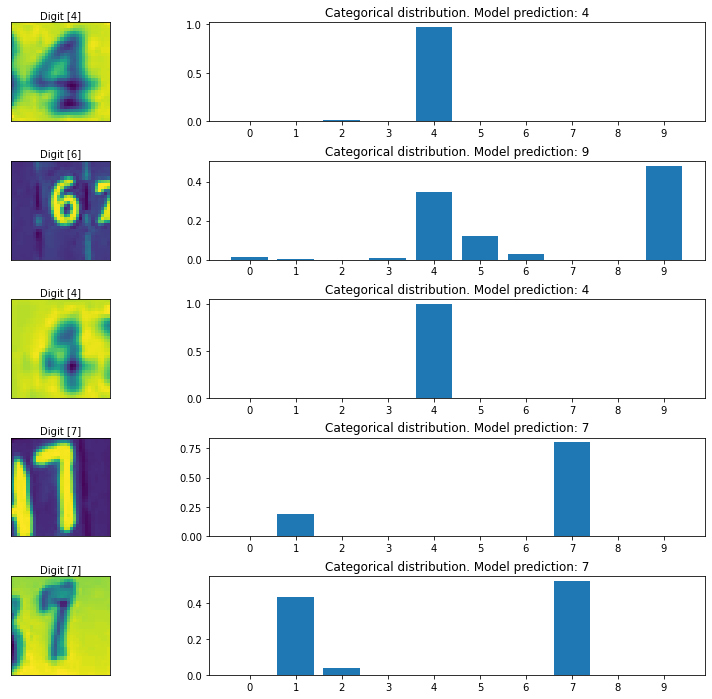

In [75]:




# selecting 5 images and corresponding labels from the test set
#  and displaying  images with their labels

scaled_test_images=np_x_test
test_labels=y_test

num_test_images = scaled_test_images.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = scaled_test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = CNN_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(9., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()



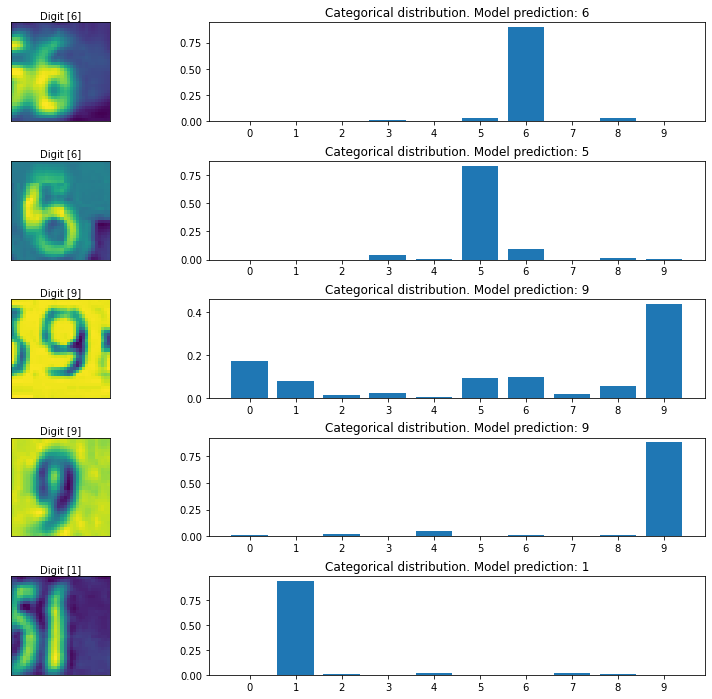

In [76]:



# Randomly select 5 images and corresponding labels from the test set
#  and display the images with their labels

scaled_test_images=np_x_test
test_labels=y_test
num_test_images = scaled_test_images.shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = scaled_test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = MLP_model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(9., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
plt.show()